In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import os

# Change this depending on your data.
taxonomic_rank = 'Genus'
base_path = "pipelines/camisimGI/bio4"
rel_abund_file = "s1_genus_relabund.csv"
program_name = "Biobakery4"
sample_id = "s1"

expected_input = "pipelines/camisimGI/s1_expected.csv"

In [ ]:
# Generate the expected result from the tsv file. Returns a dataframe.
def generate_expected(input_path: str, plot: bool = False) -> pd.DataFrame:
    expected = pd.read_csv(input_path, sep=',', index_col=0, names=['Organism', 'Counts'], header=0)
    expected = expected[['Counts']].astype(int)

    # Calculate expected relative abundance.
    expected['RA'] = expected['Counts'] / expected['Counts'].sum()

    # Let's split the organism index into two columns to find the genera.
    orgs = expected.index.to_list()
    genus = [org.strip().split(' ')[0] for org in orgs]
    genus = [x.replace('M.', 'Micromonospora') for x in genus]

    # Apparently, propionibacterium have been renamed to cutibacterium.
    genus = [x.replace('Propionibact.', 'Cutibacterium') for x in genus]

    # Add the columns to the dataframe.
    expected['Genus'] = genus
    # display(expected.head(12))

    # Group by genus and sum the counts for overlapping genera.
    exp_genus = expected.groupby('Genus').sum()
    exp_genus.sort_values('RA', ascending=False, inplace=True)

    if plot:
        exp_genus.plot.bar(y='RA', figsize=(8, 5), legend=False, title='Expected Relative Abundance')
    
    return exp_genus

# Use generate_expected to generate the expected result for the bmock12 data.
# exp_genus = generate_expected('pipelines/bmock12/s1_exp_raw.csv')
# exp_genus["RA"].to_csv('pipelines/bmock12/s1_expected.csv', index_label="Genus")

In [ ]:
# For camisim, we can just read the csv in directly.
exp_genus = pd.read_csv(expected_input, index_col=0, names=['Genus', 'RA'], header=0)
exp_genus = exp_genus.where(exp_genus['RA'] > 0.001).dropna()

(exp_genus.where(exp_genus['RA'] > 0.001).dropna()).to_csv('pipelines/camisimGI/s2_genus_pretty.csv', index_label="Genus")

In [ ]:
def generate_experimental_df(input_path: str, index_name: str) -> pd.DataFrame:
    # Now, load in the experimental values.
    r_genus = pd.read_csv(input_path, index_col=0, names=[index_name, "RA"], header=0)
    # display(r_genus.head(12))
    r_genus = r_genus[['RA']].astype(float)

    return r_genus

# Instead, let's concat the two dataframes into long format and add a column from where it originated.
def long_format(df1, df2):
    merged = pd.concat([df1, df2], axis=0)

    # !!! This is slick
    merged['Source'] = ['Expected'] * len(df1) + ['Observed'] * len(df2)

    return merged

# result_genus = generate_experimental_df(os.path.join(base_path, rel_abund_file), taxonomic_rank)
# display(result_genus.head(12))
# merged_lf = long_format(exp_genus, result_genus)

In [ ]:
def linear_regression(df: pd.DataFrame, exp_df: pd.DataFrame, plot: bool = False, save_path: str = None) -> pd.DataFrame:
    # Merge on the genus key for easy plotting. The expected results are on the left, the observed on the right.
    # linear_df = exp_genus.merge(df, left_index=True, right_index=True)

    # try join because the left merge will drop the genera that are not in the observerd results, but we want to show that the experimental missed it.
    linear_df = exp_df.join(df, how='left', lsuffix='_x', rsuffix='_y')
    linear_df.fillna(0, inplace=True)

    # Linear regression with scikit.
    X = linear_df['RA_x'].values.reshape(-1, 1)
    Y = linear_df['RA_y'].values.reshape(-1, 1)
    reg = LinearRegression().fit(X, Y)
    y_pred = reg.predict(X)

    # Scatter plot of RA_x vs. RA_y.
    if plot:
        fig = plt.figure(figsize=(10, 8))
        plt.scatter(linear_df['RA_x'], linear_df['RA_y'], color='black')

        # Calculate mean absolute error.
        mae = np.mean(np.abs(linear_df['RA_x'] - linear_df['RA_y']))

        # Regression line.
        plt.plot(X, y_pred, color='red', linewidth=2)
        # Labels.
        plt.xlabel('Expected Relative Abundance')
        plt.ylabel('Observed Relative Abundance')
        plt.title(f'Expected vs. Observed Relative Abundance for {program_name} {taxonomic_rank}')

        # Add r^2 value.
        plt.text(0.1, 0.9, f'r^2 = {reg.score(X,Y):.4f}', transform=plt.gca().transAxes)
        # Add MAE.
        plt.text(0.1, 0.85, f'MAE = {mae:.4f}', transform=plt.gca().transAxes)

        # Add line y = x.
        plt.plot([0, 1], [0, 1], color='blue', linewidth=2, linestyle='--')

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

    return linear_df
    
# linear_regression(result_genus, exp_genus, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bivariate_{taxonomic_rank}.png"))

In [ ]:
# Bar plot of RA_x vs. RA_y side by side.
# sns.set_style("whitegrid")
def bar_plot(df: pd.DataFrame, plot: bool = False, save_path: str = None, program=program_name, title=f'Expected vs. Observed Relative Abundance for {program_name} {taxonomic_rank}', hue_category='Source'):
    subset = pd.DataFrame()

    for x, y in df.groupby(taxonomic_rank):
        if y["Source"].values[0] == "Expected":
            subset = pd.concat([y, subset], axis=0)

    subset = subset.where(subset['RA'] > 0.001).dropna()

    if plot:
        display(subset.head(12))
        display(df.head(12))
        # Plot a category bar chart with the colors besed on the source.
        fig = plt.figure(figsize=(10, 8))
        ax = sns.barplot(x=subset.index, y='RA', hue=hue_category, data=subset, errorbar=None)
        # ax.bar_label(ax.containers[0], fmt='%.2e', label_type='center')
        # ax.bar_label(ax.containers[1], fmt='%.2e', label_type='edge')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
        ax.set_title(title)
        ax.set_xlabel('Genus')
        ax.set_ylabel('Relative Abundance')

        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.show()

# bar_plot(merged_lf, plot=True, save_path=os.path.join(base_path, f"{sample_id}_bars_{taxonomic_rank}.png"))

# Multisample
## Utilities

In [ ]:
# We will now aggregate the differences by pipeline. To do this, we will start at the root and walk down, looking for "relabund" files.

root_dir = "pipelines/tourlousse/"

def get_all_expected(root_dir: str, rank="genus"):
    combined_expected = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if f"expected_{rank}" in f and f.endswith(".csv"):
                df = pd.read_csv(os.path.join(root, f), index_col=0, names=['Genus', 'RA'], header=0)
                df["Source"] = "Expected"
                df["SampleID"] = f.split("_")[0]
                combined_expected = pd.concat([combined_expected, df], axis=0)


    # Files are of s#_expected.csv, so we can split on the underscore and take the first part.

    return combined_expected

In [ ]:
def get_relabund_files(root_dir: str, rank="genus"):
    combined_df = pd.DataFrame()
    for root, dirs, files in os.walk(root_dir):
        for f in files:
            if "relabund" and rank in f and f.endswith(".csv"):
                # print(root, f)
                p = os.path.join(root, f)
                exp = generate_experimental_df(p, taxonomic_rank)

                # Add a column to the experimental dataframe with the pipeline name.
                exp['Source'] = os.path.dirname(p).split('/')[-1]

                # Add sampleID to the experimental dataframe.
                exp['SampleID'] = os.path.basename(p).split('_')[0]

                # Add the experimental dataframe to the combined dataframe.
                combined_df = pd.concat([combined_df, exp], axis=0)

    # Ensure that the RA column is a float.
    combined_df['RA'] = combined_df['RA'].astype(float)

    return combined_df

In [ ]:
def fully_combined():
    combined_df = get_relabund_files(root_dir)
    combined_expected = get_all_expected(root_dir)

    # Merge the expected and experimental dataframes.
    merged = pd.concat([combined_expected, combined_df], axis=0)
    merged = merged.reset_index()
    merged = merged.rename(columns={'index': 'Genus'})
    merged = merged.set_index('Genus')

    # display(merged.head())

    return merged

## Multisample with Different Expected Values

In [ ]:
def plot_by_sample(output_dir, hue_category='Source'): 
    full_df = fully_combined()
    for sample_id, df in full_df.groupby('SampleID'):
        title = f"Expected vs. Observed Relative Abundance for {sample_id} ({taxonomic_rank})"
        # display(df.head())
        bar_plot(df, plot=True, save_path=os.path.join(output_dir, f"{sample_id}_bars_{taxonomic_rank}_all.png"), title=title)

# plot_by_sample(root_dir, hue_category='SampleID')

In [126]:
def linear_regression(X, Y):
    reg = LinearRegression().fit(X, Y)
    y_pred = reg.predict(X)

    return reg, y_pred

def linear_plot(input_df: pd.DataFrame, title, sample_id, hue_category="Source_observed", save_path=None):
    # fig = plt.figure(figsize=(20, 20))
    ax = sns.lmplot(x="RA_expected", y="RA_observed", hue=hue_category, data=input_df, fit_reg=True, height=7, aspect=11/7, ci=None)

    # Make linear regression for each pipeline.
    pipeline_offset = 0.90
    for heading, dataframe in input_df.groupby("Source_observed"):
        x = dataframe["RA_expected"].values.reshape(-1, 1)
        y = dataframe["RA_observed"].values.reshape(-1, 1)
        reg, y_pred = linear_regression(x, y)

        # Calculate MAE.
        mae = np.mean(np.abs(dataframe['RA_expected'] - dataframe['RA_observed']))

        # Add r^2
        plt.text(0.1, pipeline_offset, f'r^2 = {reg.score(x,y):.4f} for {heading}', transform=plt.gca().transAxes)
        # Add MAE
        plt.text(0.4, pipeline_offset, f'MAE = {mae:.4f} for {heading}', transform=plt.gca().transAxes)

        pipeline_offset -= 0.05

    # Add title.
    plt.title(title)
    if save_path is not None:
        ax.figure.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

In [ ]:
# Convert from Genus, RA, Source, SampleID to Genus RA_x, RA_y, Source, SampleID.
def convert_to_bivariate(df: pd.DataFrame):
    for sample, sample_df in df.groupby('SampleID'):
        bivariate_df = pd.DataFrame()
        # Get the expected dataframe.
        expected = sample_df[sample_df['Source'] == 'Expected']
        # Get the experimental dataframe.
        experimental = sample_df[sample_df['Source'] != 'Expected']

        # Merge the expected and experimental dataframes.
        merged = pd.merge(expected, experimental, on='Genus', how='left', suffixes=('_expected', '_observed'))
        merged['SampleID'] = sample
        # merged["RA_observed"] = merged["RA_observed"].fillna(0)

        # Add the merged dataframe to the bivariate dataframe.
        bivariate_df = pd.concat([bivariate_df, merged], axis=0)

        # bivariate_df = bivariate_df.sort_values(by='RA_expected', ascending=False).head(30)

        linear_plot(bivariate_df, "Bivariate Linear Regression for Sample " + sample, sample, hue_category="Source_observed", save_path=os.path.join(root_dir, f"{sample}_linear_{taxonomic_rank}_all.png"))

    return bivariate_df

bivariate_df = convert_to_bivariate(fully_combined())

## Multiple Samples (Replicates) with One Expected

In [ ]:
# This function is used for multiple samples from the same pipeline against the same expected.
def plot_many_versus_expected(output_dir, in_df, rank):
    exp = get_all_expected(root_dir, rank)
    for pipeline, df in in_df.groupby('Source'):
        print(pipeline)
        if pipeline != "Expected" and pipeline != "tourlousse":
            fig = plt.figure(figsize=(15, 12))

            df = df.where(df['RA'] > 0.001).dropna()

            # Add the expected dataframe to the combined dataframe.
            merged = pd.concat([exp, df], axis=0)

            ax = sns.barplot(x=merged.index, y='RA', hue="SampleID", data=merged, errorbar=None)
            # ax.bar_label(ax.containers[0], fmt='%.2e', label_type='center')
            # ax.bar_label(ax.containers[1], fmt='%.2e', label_type='edge')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

            title = f"Expected vs. Observed Relative Abundance for {rank} using {pipeline}"
            ax.set_title(title)
            ax.set_xlabel('Genus')
            ax.set_ylabel('Relative Abundance')

            plt.savefig(os.path.join(output_dir, f"{pipeline}", f"{pipeline}_bars.png"), dpi=300, bbox_inches='tight')

plot_many_versus_expected(root_dir, fully_combined(), "genus")

,RA_expected,Source_expected,SampleID_expected,RA_observed,Source_observed,SampleID_observed
Genus,,,,,,
Akkermansia,0.06,Expected,expected,0.040927,jams,SRR17380244
Akkermansia,0.06,Expected,expected,0.042165,jams,SRR17380242
Akkermansia,0.06,Expected,expected,0.040841,jams,SRR17380241
Akkermansia,0.06,Expected,expected,0.041186,jams,SRR17380243
Akkermansia,0.06,Expected,expected,0.040887,jams,SRR17380245


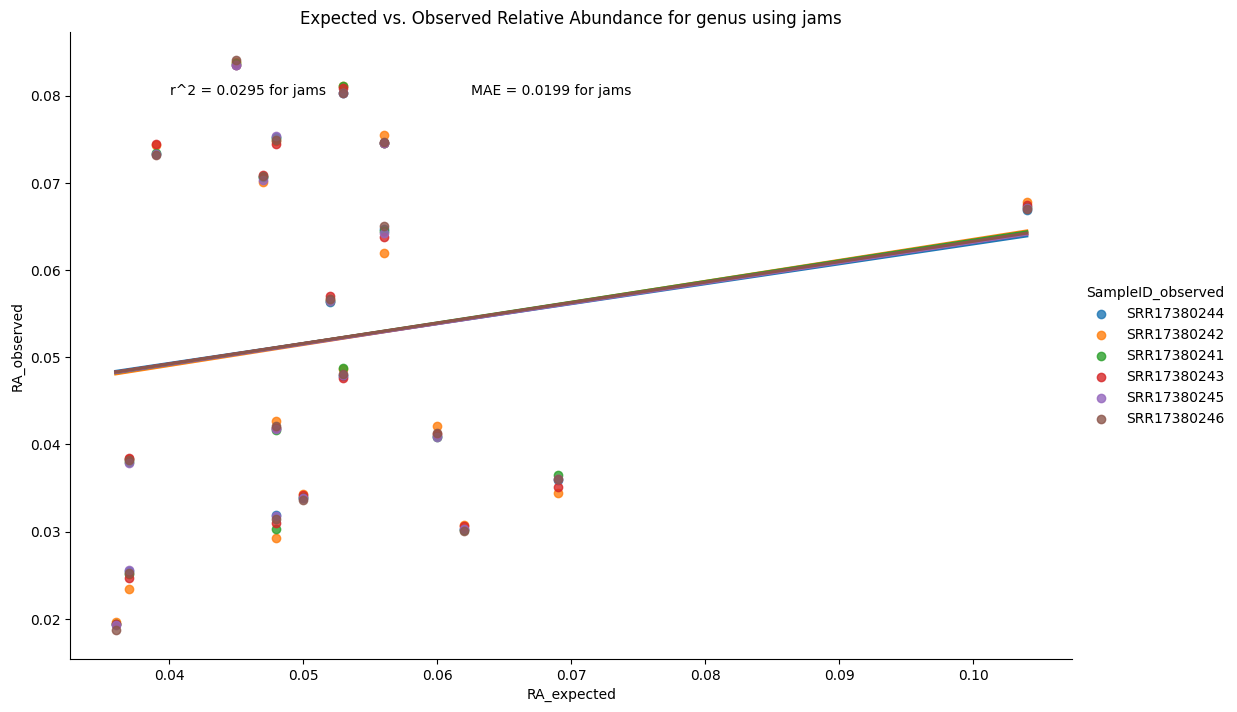

,RA_expected,Source_expected,SampleID_expected,RA_observed,Source_observed,SampleID_observed
Genus,,,,,,
Akkermansia,0.06,Expected,expected,0.0404,wgsa,sSRR17380241
Akkermansia,0.06,Expected,expected,0.0416,wgsa,sSRR17380242
Akkermansia,0.06,Expected,expected,0.0405,wgsa,sSRR17380244
Akkermansia,0.06,Expected,expected,0.0408,wgsa,sSRR17380246
Akkermansia,0.06,Expected,expected,0.0404,wgsa,sSRR17380245


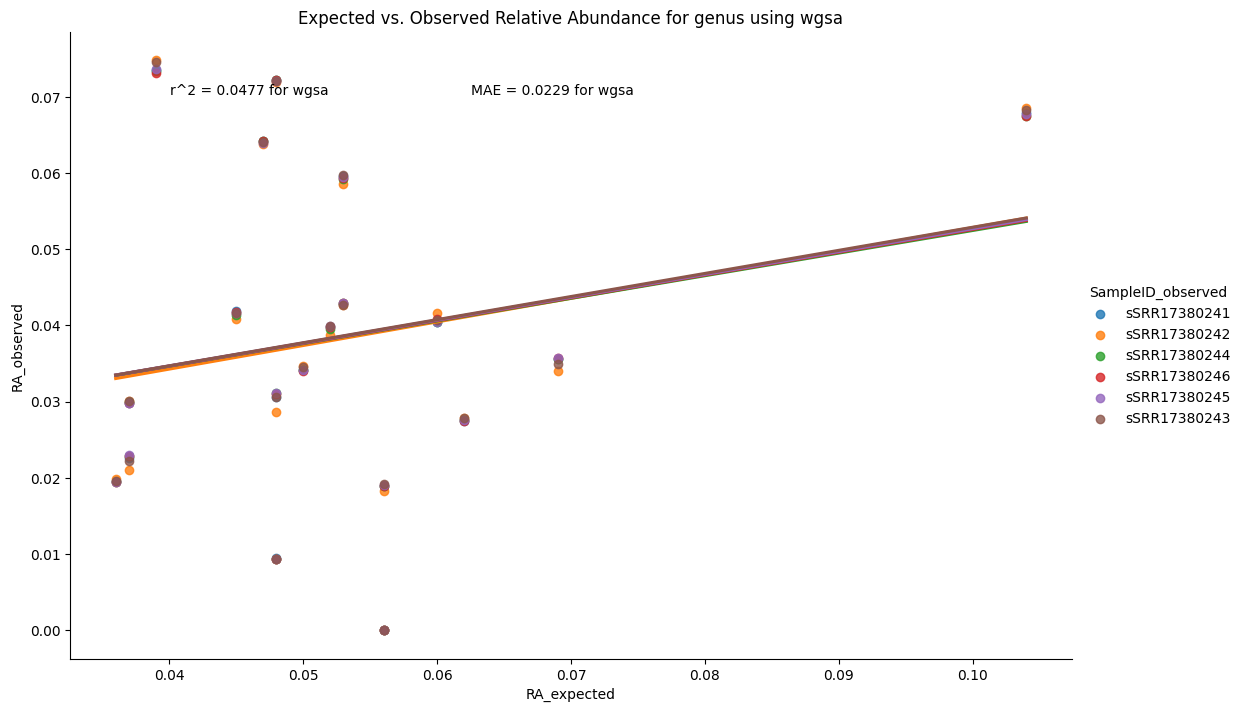

,RA_expected,Source_expected,SampleID_expected,RA_observed,Source_observed,SampleID_observed
Genus,,,,,,
Akkermansia,0.06,Expected,expected,0.069695,woltka,SRR17380244
Akkermansia,0.06,Expected,expected,0.072170,woltka,SRR17380242
Akkermansia,0.06,Expected,expected,0.069561,woltka,SRR17380241
Akkermansia,0.06,Expected,expected,0.070282,woltka,SRR17380243
Akkermansia,0.06,Expected,expected,0.069409,woltka,SRR17380245


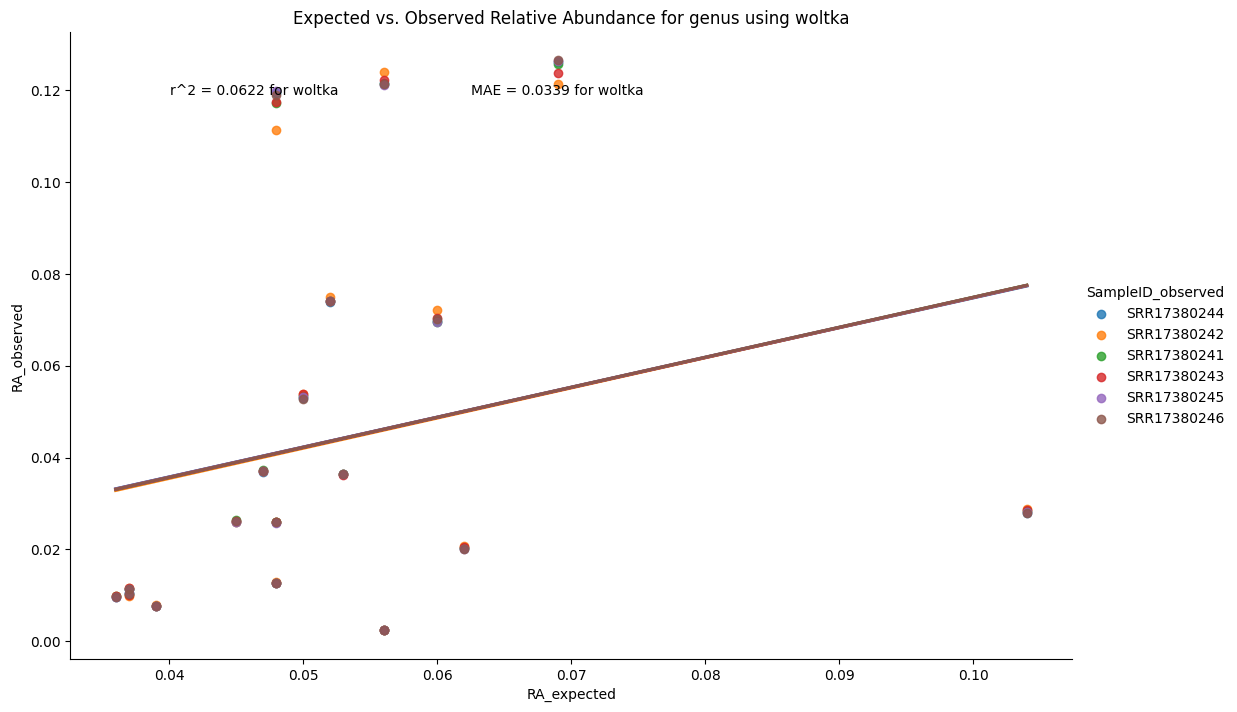

In [127]:
# This function will plot the expected vs. observed for each sample in each pipeline.
# There is only one expected value for each sample since they are replicates.
# This will be a bivariate plot.
def plot_many_versus_expected_bivariate(observed_df, expected_df, rank):
    # First, we need to make a df of observed vs. expected for each sample.
    for pipeline, pipeline_df in observed_df.groupby("Source"):
        # Plotting expected vs expected is useless.
        if pipeline == "tourlousse":
            continue

        merged = pd.merge(expected_df.copy(), pipeline_df, on='Genus', how='left', suffixes=('_expected', '_observed'))
        display(merged.head())

        save_path = os.path.join(root_dir, pipeline, f"{pipeline}_bivariate_{rank}_all_samples.png")

        linear_plot(merged, f"Expected vs. Observed Relative Abundance for {rank} using {pipeline}", pipeline, hue_category="SampleID_observed", save_path=save_path)

plot_many_versus_expected_bivariate(get_relabund_files(root_dir), get_all_expected(root_dir, "genus"), "genus")